In [18]:
import weaviate
from weaviate.classes.config import Configure, Property, DataType, Multi2VecField
import base64
from PIL import Image
import io
import os
from tqdm import tqdm
import json


## Utility Functions

In [5]:
def read_image_data(image_path):
    """Read image as base64 and PIL object, caching to avoid redundant reads"""
    with open(image_path, "rb") as img_file:
        raw_data = img_file.read()
        base64_data = base64.b64encode(raw_data).decode("utf-8")
        pil_img = Image.open(io.BytesIO(raw_data))
    return base64_data, pil_img

def process_metadata(metadata, max_chars=200):
    """Process captions from metadata"""
    captions = metadata.get("captions", [])
    concatenated = " ".join(captions)[:max_chars] if captions else "No captions available"
    return concatenated

## Schema Creation

In [6]:
def create_flickr_schema_multi2vec(client, collection_name, image_weight=0.5):
    """Create schema for multi2vec-clip"""
    if client.collections.exists(collection_name):
        client.collections.delete(collection_name)
        print(f"existing {collection_name} deleted, creating a new one.")
    
    image_weight = round(image_weight, 2)
    text_weight = round(1.0 - image_weight, 2)

    client.collections.create(
        collection_name,
        properties=[
            Property(name="image", data_type=DataType.BLOB),
            Property(name="image_id", data_type=DataType.TEXT),
            Property(name="captions", data_type=DataType.TEXT),
        ],
        vectorizer_config=[
            Configure.NamedVectors.multi2vec_clip(
                name="image_vector",
                image_fields=[Multi2VecField(name="image", weight=image_weight)],
                text_fields=[Multi2VecField(name="captions", weight=text_weight)]
            )
        ]
    )
    print(f"Created {collection_name} schema")

## Import Data to Collection

In [7]:
def import_data_multi2vec(client, data_dir, collection_name, batch_size=100):
    """Import data with multi2vec-clip"""
    collection = client.collections.get(collection_name)
    images_dir = os.path.join(data_dir, "images")
    metadata_dir = os.path.join(data_dir, "metadata")
    metadata_files = [f for f in os.listdir(metadata_dir) if f.endswith('.json')]
    print(f"Importing {len(metadata_files)} images for multi2vec")

    batch_errors = []
    with collection.batch.fixed_size(batch_size=batch_size) as batch:
        for metadata_file in tqdm(metadata_files):
            try:
                with open(os.path.join(metadata_dir, metadata_file), 'r') as f:
                    metadata = json.load(f)
                
                image_path = os.path.join(images_dir, f"image_{metadata['image_id']}.jpg")
                image_data, _ = read_image_data(image_path)
                captions = process_metadata(metadata)
                
                batch.add_object(
                    properties={
                        "image": image_data,
                        "image_id": metadata["image_id"],
                        "captions": captions
                    }
                )
            except Exception as e:
                batch_errors.append(f"Error processing {metadata_file}: {str(e)}")
                continue
    if batch_errors:
        print(f"Encountered {len(batch_errors)} errors during batch import")
        for err in batch_errors[:5]:  # Print first 5 errors
            print(err)
    print("Finished multi2vec import")

In [22]:
# Connect to Weaviate
client = weaviate.connect_to_local()

data_dir = "/Users/roshanakzakizadeh/Projects/multimodal_comparison/flickr30k_sample"

create_flickr_schema_multi2vec(client, collection_name="Flickr30k_multi2vec", image_weight=0.5)

import_data_multi2vec(client, data_dir, collection_name="Flickr30k_multi2vec")

client.close ()

/Users/roshanakzakizadeh/Projects/weaviate_multimodal_search/.venv/lib/python3.10/site-packages/weaviate/collections/classes/config.py:1963: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:
/Users/roshanakzakizadeh/Projects/weaviate_multimodal_search/.venv/lib/python3.10/site-packages/weaviate/collections/classes/config_vectorizers.py:412: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  for cls_field in self.model_fields:


Created Flickr30k_multi2vec schema
Importing 598 images for multi2vec


 61%|██████    | 366/598 [00:10<00:00, 1229.46it/s]{'message': 'Failed to send all objects in a batch of 100', 'error': "WeaviateBatchError('Query call with protocol GRPC batch failed with message Deadline Exceeded.')"}
{'message': 'Failed to send all objects in a batch of 100', 'error': "WeaviateBatchError('Query call with protocol GRPC batch failed with message Deadline Exceeded.')"}
{'message': 'Failed to send 100 objects in a batch of 100. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
{'message': 'Failed to send 100 objects in a batch of 100. Please inspect client.batch.failed_objects or collection.batch.failed_objects for the failed objects.'}
100%|██████████| 598/598 [05:44<00:00,  1.74it/s]  
{'message': 'Failed to send all objects in a batch of 100', 'error': "WeaviateBatchError('Query call with protocol GRPC batch failed with message Deadline Exceeded.')"}
{'message': 'Failed to send all objects in a batch of 100', 'err

Finished multi2vec import


## Query Search

In [23]:
import weaviate.classes as wvc
import time

In [26]:
def query_search(collection_name: str, queries: list[str], k: int):
    """
    Runs query search inside the given collection
    collection_name: name of the collection on Weaviate
    queries: series of words or phrases
    k : number of items to retrieve from the collection
    """
    client = weaviate.connect_to_local()
    collection = client.collections.get(collection_name)
    response = collection.aggregate.over_all(total_count=True)
    print(f"{collection_name} collection size is : {response.total_count}")

    results = {}

    for query in queries:
        try:
            start_time = time.time()
            response = collection.query.near_text(
                query=query,
                limit=k,
                return_metadata=wvc.query.MetadataQuery(distance=True)
            )        

            similarities = [obj.metadata.distance for obj in response.objects]
            print(f"Query: {query}, Similarities: {similarities}")
            latency = time.time() - start_time
            retrieved_ids = [obj.properties['image_id'] for obj in response.objects]
            retrieved_captions = [obj.properties['captions'] for obj in response.objects]

            results[query] = {
                "latency": latency,
                "image_ids": retrieved_ids,
                "captions": retrieved_captions
            }
        except Exception as e:
            print(f"error processing query {query} in {collection_name}: {str(e)}")
            results[query] = {
                "latency": 0.0,
                "image_ids": [],
                "captions": []
            }
    
    client.close()
    return results

In [27]:
# 
collection_name = "Flickr30k_multi2vec"
queries = ["dog", "book", "children playing"]
results = query_search(collection_name=collection_name, queries=queries, k=3)

Flickr30k_multi2vec collection size is : 198
Query: dog, Similarities: [0.382515549659729, 0.38716399669647217, 0.3893381953239441]
Query: book, Similarities: [0.349753201007843, 0.4171041250228882, 0.4236533045768738]
Query: children playing, Similarities: [0.3753165006637573, 0.401589035987854, 0.4033859968185425]


In [46]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_search_results(results: dict, query: str, images_dir: str):
    """
    displays images along with their captions.
    """
    print(f"Images retrieved for the query {query}:")

    for img_id in results[query]['image_ids']:
        image_path = os.path.join(images_dir, "image_" + img_id + '.jpg')
        img = Image.open(image_path)
        plt.figure()
        plt.imshow(img)

        caption = results[query]['captions'][results[query]['image_ids'].index(img_id)]
        plt.title(f'Image ID {img_id}. Caption: {caption}', wrap=True)

        plt.axis('off')
        plt.show()

Images retrieved for the query dog:


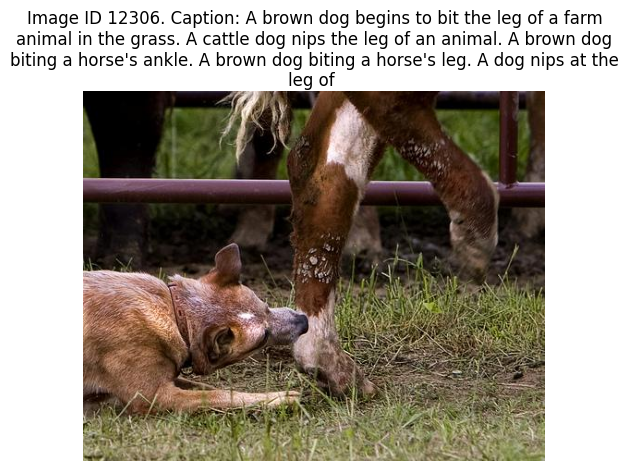

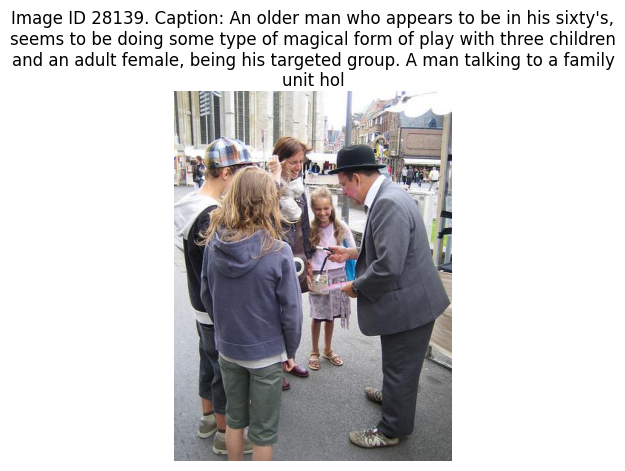

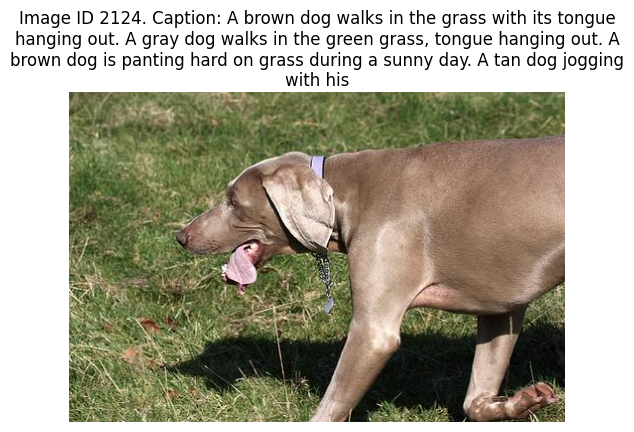

Images retrieved for the query book:


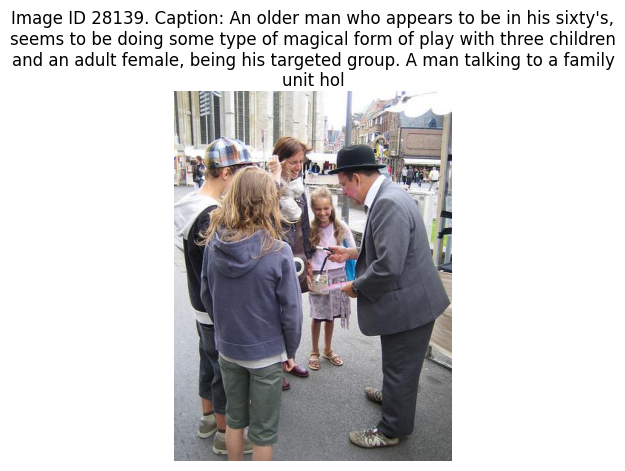

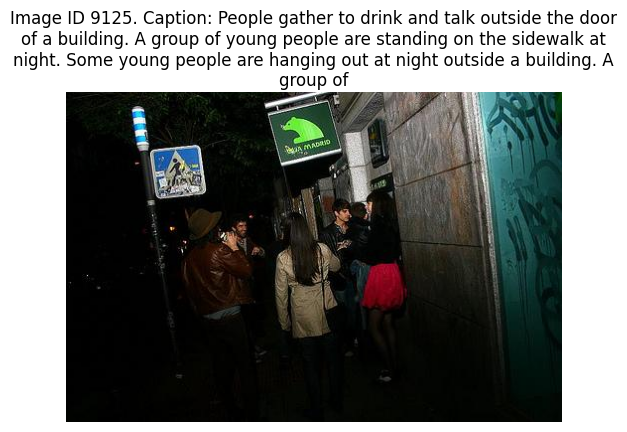

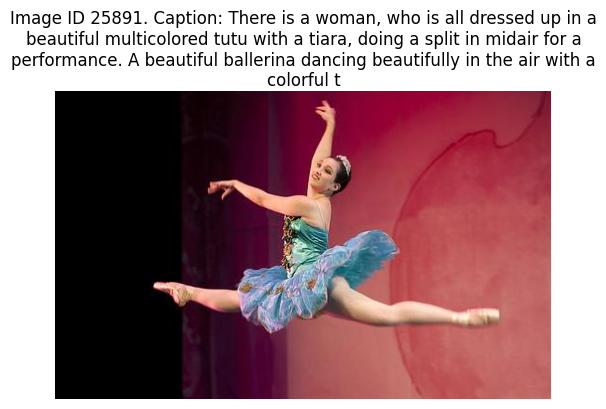

Images retrieved for the query children playing:


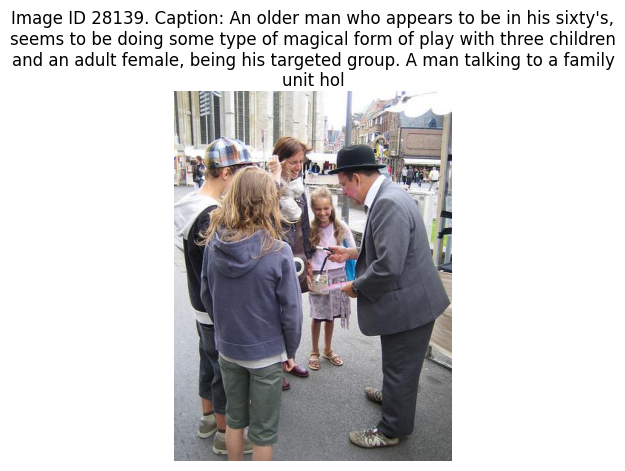

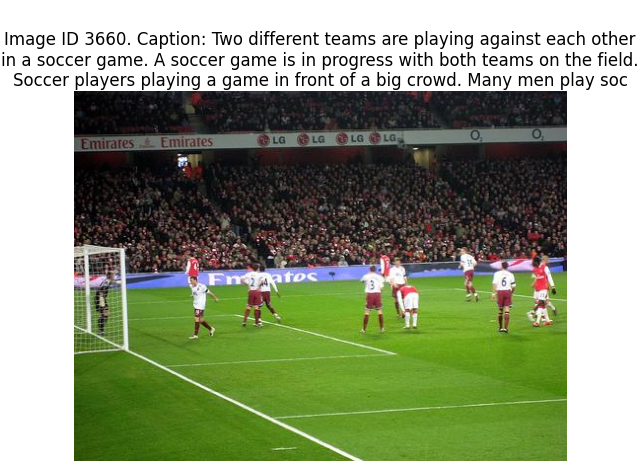

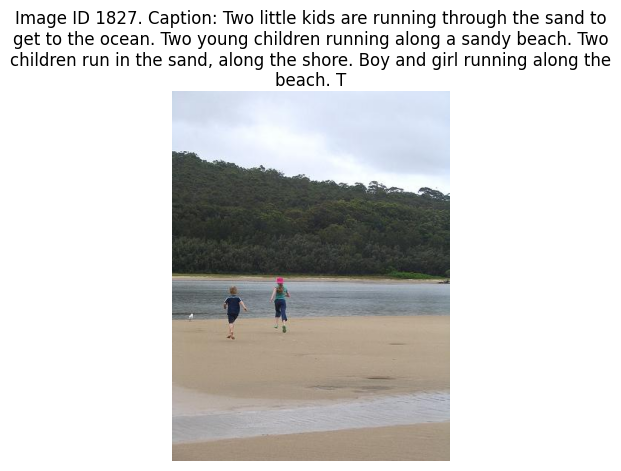

In [47]:
for query in queries:
    display_search_results(results=results, query=query, images_dir=data_dir+'/images')